# Train 3D network on Memento

In [9]:
# Imports
import sys
print("sys.executable:",sys.executable)

import numpy as np
import keras
import tensorflow as tf
import os
import sys
import matplotlib.pyplot as plt
from scipy.stats import spearmanr
from keras.optimizers import Adam, SGD
import pickle
import json

sys.path.append('../src/')
from generator import VideoSeqGenerator, preprocess_rgb_fast, load_vids_opencv
from vid_utils import load_video_opencv, plot_frames
from memento_utils import *
from captioning_utils import *
import i3d_config as cfg
from keras_models import build_i3d_custom, build_model_multigpu

%load_ext autoreload
%autoreload 2


# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU

# sess = tf.Session(config=config)
# set_session(sess)  # set this TensorFlow session as the default session for Keras

sys.executable: /usr/bin/python3
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [10]:
import keras
import tensorflow as tf
import numpy as np
print("keras version:", keras.__version__)
print("tf version:", tf.__version__)
print("np version:", np.__version__)

keras version: 2.3.1
tf version: 1.14.0
np version: 1.18.5


In [11]:
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
print(os.environ['CUDA_VISIBLE_DEVICES'])

0


In [12]:
%%bash
nvidia-smi

Fri Jul 17 18:36:56 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.82       Driver Version: 440.82       CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN RTX           Off  | 00000000:1A:00.0 Off |                  N/A |
| 41%   39C    P8    26W / 280W |  23656MiB / 24220MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  TITAN RTX           Off  | 00000000:68:00.0  On |                  N/A |
| 41%   48C    P2    69W / 280W |  23573MiB / 24217MiB |     34%      Default |
+-------------------------------+----------------------+----------------------+
        

# Key vars

In [13]:
data_type = 'rgb'
dataset = 'memento10k'
gpus = 1
resc = 1
use_sw = 1
bs = 20
do = 0.3
loss_type = 'alphamse'

# Fetch video names, alphas, memorability scores and captions


In [15]:
if os.uname()[1] == 'visiongpu30':
    data_path = '../../../moments_raw/sources_numpy_256/' if data_type=='rgb' else '../../../moments_flow/sources_flow_down1_tvl1_skip1/'
    labels_path = '../../memento_data/'
    names_with_slash = False
elif os.uname()[1] == 'cfosco-lambda':
    data_path = '../../../../../../Datasets/memento_raw/sources_numpy_256/' if data_type=='rgb' else '../../../../../../Datasets/memento_raw/sources_flow_down1_tvl1_skip1/'
    labels_path = '../../memento_data/'
    names_with_slash = False
else:
    data_path = '../../memento'
    labels_path = '../../memento_data'
    names_with_slash = True

    
    
train_data = '../../../../../../Dropbox/Graduate Studies/MIT/Research/memento_project/memento/memento_train_data.json' 
val_data = '../../../../../../Dropbox/Graduate Studies/MIT/Research/memento_project/memento/memento_val_data.json' 
test_data = '../../../../../../Dropbox/Graduate Studies/MIT/Research/memento_project/memento/memento_test_data.json' 

train_names, val_names, test_names, name_to_mem_alpha, train_captions, val_captions, test_captions = get_memento_data(train_data, val_data, test_data)
    


# bert_embeddings = json.load(open(os.path.join(labels_path, 'bert_embeddings.json')))
bert_embeddings = json.load(open('../../../../../../Dropbox/Graduate Studies/MIT/Research/memento_project/memento/bert_embeddings.json'))

bert_embeddings_new = {'train':{}, 'val':{}, 'test':{}}
if not names_with_slash:
    for split,d in bert_embeddings.items():
        for k,v in d.items():
            new_k = "_".join([k.split('/')[0].replace('+','-')] + k.split('/')[1:])
            new_k = new_k.replace('.mp4', '.npy')
            bert_embeddings_new[split][new_k] = v 
            
    bert_embeddings = bert_embeddings_new
del bert_embeddings_new

# for k,v in bert_embeddings['train'].items():
#     print(k,v)
#     break

# input_captions_train, target_captions_train = prepare_caption_data('../../memento_data/memento_train_tokenized_captions.json', 
#                                                                    word_embeddings='../../memento_data/vocab_embedding.json',
#                                                                    return_backward=False, 
#                                                                    caption_format=caption_format,
#                                                                   names_with_slash=names_with_slash)

# input_captions_val, target_captions_val = prepare_caption_data('../../memento_data/memento_val_tokenized_captions.json', 
#                                                                    word_embeddings='../../memento_data/vocab_embedding.json',
#                                                                    return_backward=False, 
#                                                                    caption_format=caption_format,
#                                                                   names_with_slash=names_with_slash)

# embedding_matrix = get_embedding_matrix('../../memento_data/vocab_embedding.json',
#                                         '../../memento_data/vocab.json')

# print("embedding_matrix.shape:",embedding_matrix.shape)


## FUSE LABEL_DICTIONARIES
str2label_train = add_sentence_embeddings_to_str2label(name_to_mem_alpha, bert_embeddings['train'])
str2label_val = add_sentence_embeddings_to_str2label(name_to_mem_alpha, bert_embeddings['val'])

for k,v in str2label_train.items():
    print(k)
    print(v)
    break

print('Loaded %d train videos and %d val videos\n' % (len(train_names), len(val_names)))
print("Length bert embeddings train+val+test:", len(bert_embeddings['train'])+len(bert_embeddings['val'])+len(bert_embeddings['test']))

 
# Check if all names are in dict
train_not_in_dict=0
for tn in train_names:
    if tn not in bert_embeddings['train'].keys():
        print('Train vid not in bert dict:',tn)
        train_not_in_dict+=1
print('train_not_in_dict',train_not_in_dict)
        
val_not_in_dict=0
for tn in val_names:
    if tn not in bert_embeddings['val'].keys():
        print('Val vid not in bert dict:',tn)
        val_not_in_dict+=1
print("val_not_in_dict",val_not_in_dict)
        

KeyError: 'walking_1-1-6-9-6-1-9-6-3511696196.npy'

In [ ]:
# Show bert embedding dict structure
for k,v in bert_embeddings['train'].items():
    print(v)
    print(len(v['embedded'][0]))
    print([np.linalg.norm(np.array(v['embedded'][i]) - v['embedded'][i+1]) for i in range(4)])
    break
    
np.mean(v['embedded'], axis=0)

### Bert embedding dict structure:

key: video_name.npy

value: dict with keys "raw" and "embedded"
   - "raw": list of 5 string captions
   - "embedded": list of 5 1024 dimensional arrays

## Get mem weights if needed

In [ ]:
if use_sw:
    factor = 3
    mem_weights = get_sample_weights([name_to_mem_alpha[n][0] for n in train_names], factor=factor)
    alpha_weights = get_sample_weights([name_to_mem_alpha[n][1] for n in train_names], factor=factor)
    
    sw=np.array(mem_weights)
else:
    sw=None

In [ ]:
print([name_to_mem_alpha[n] for n in train_names][:10])
# print(mem_weights[:10])

# Generator

In [10]:
# Instantiating generator


gen_train = VideoSeqGenerator(files=np.array(train_names),
                            batch_size=bs, 
                            dataset_path=data_path,
                            label_csv= None, 
                            augment= None, #['dropout', 'cutout'],
                            load_func='npy_'+data_type,
                            load_labels_func=load_labels_mem_alpha_embedding,
                            preprocess_func='fast_'+data_type,
                            remove_excess_files=False,
                            shuffle=True,
                            is_train=True,
                            verbose=True,
                            str2label_dict = str2label_train,
                            sample_weights=sw)

gen_val = VideoSeqGenerator(files=np.array(val_names),
                            batch_size=bs, 
                            dataset_path=data_path,
                            label_csv=None,
                            augment=None,
                            load_func='npy_'+data_type,
                            load_labels_func=load_labels_mem_alpha_embedding,
                            preprocess_func='fast_'+data_type,
                            remove_excess_files=False,
                            shuffle=False,
                            is_train=False,
                            verbose=True,
                            str2label_dict = str2label_val,
                            sample_weights=sw)


Caution: batch_size (20) is not multiple of given dataset length (7004). This can cause issues with multigpu training.
Calling VideoSeqGenerator. Batch size:  20 . Number of files received: 7004 . Augmentation:  None
Caution: batch_size (20) is not multiple of given dataset length (1506). This can cause issues with multigpu training.
Calling VideoSeqGenerator. Batch size:  20 . Number of files received: 1506 . Augmentation:  None


# Test Generator


Total time on this batch: 0.9309280959423631  - it: 0 - idx: 0
Time loading: 0.5229093518573791
Time preprocessing: 0.40801381203345954
Time augmenting: 4.93205152451992e-06
Embedding label stats:
Len: 1024, Mean: 0.0015, SD: 0.6052
Distance to negative example: 4.9187
mem, alpha, np.max(b), np.min(b) 0.6463559839370363 -0.0014405872116520467 255.0 0.0


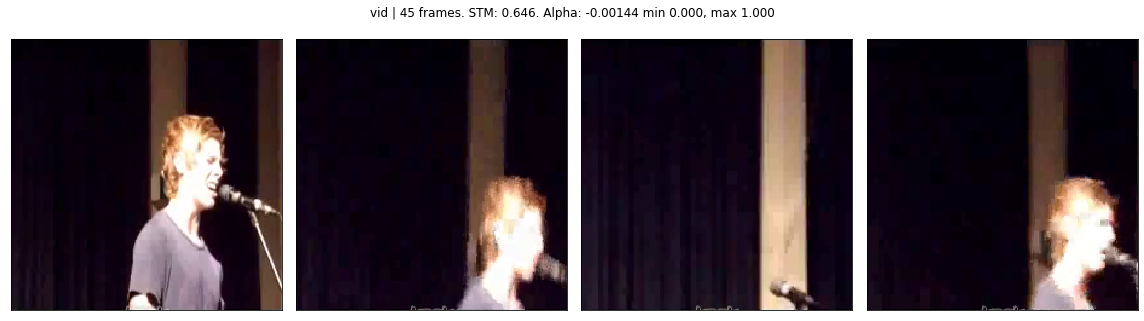

Embedding label stats:
Len: 1024, Mean: 0.0007, SD: 0.5899
Distance to negative example: 6.1905
mem, alpha, np.max(b), np.min(b) 0.6602816316516062 -0.0016431227536659629 255.0 0.0


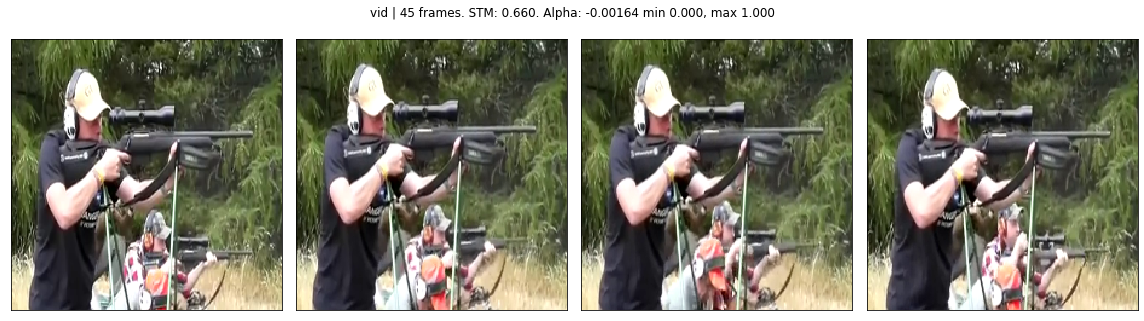

Embedding label stats:
Len: 1024, Mean: 0.0017, SD: 0.6132
Distance to negative example: 5.7561
mem, alpha, np.max(b), np.min(b) 0.9601255353231068 0.0010163482575011604 255.0 0.0


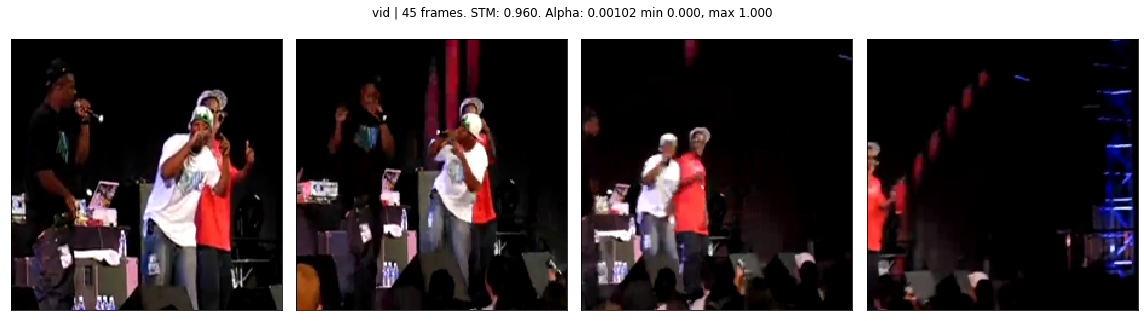

Embedding label stats:
Len: 1024, Mean: 0.0013, SD: 0.5656
Distance to negative example: 5.8253
mem, alpha, np.max(b), np.min(b) 0.19036532337660086 -0.004289093157192676 255.0 0.0


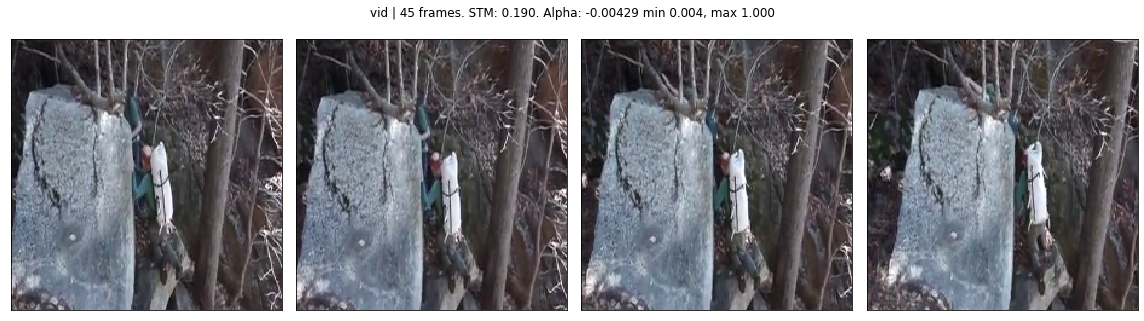

Embedding label stats:
Len: 1024, Mean: 0.0012, SD: 0.6066
Distance to negative example: 5.6267
mem, alpha, np.max(b), np.min(b) 0.756485529734203 -0.001628686806423242 255.0 0.0


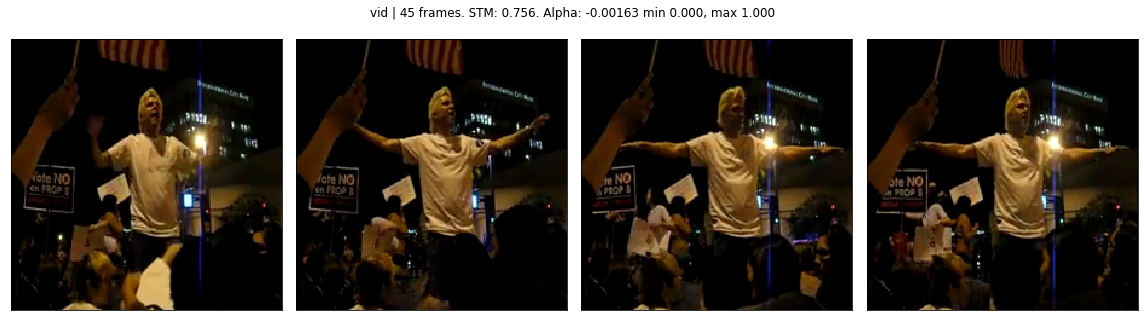

Embedding label stats:
Len: 1024, Mean: 0.0007, SD: 0.6271
Distance to negative example: 6.3497
mem, alpha, np.max(b), np.min(b) 0.7466195927102918 -0.0014681377404276422 255.0 0.0


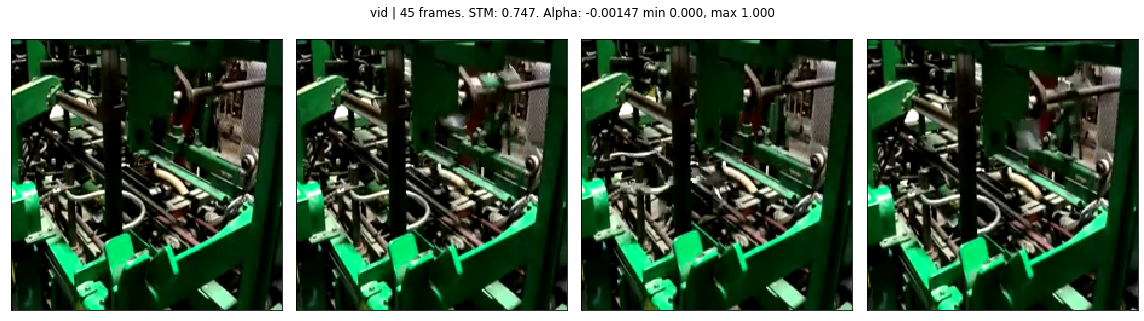

Embedding label stats:
Len: 1024, Mean: 0.0011, SD: 0.6127
Distance to negative example: 6.2550
mem, alpha, np.max(b), np.min(b) 0.6917134912112824 -0.0021743777587325463 255.0 0.0


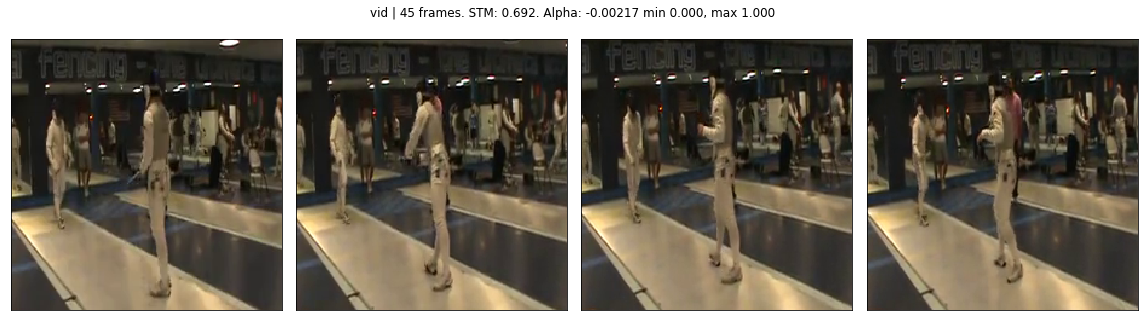

Embedding label stats:
Len: 1024, Mean: 0.0006, SD: 0.6129
Distance to negative example: 5.1177
mem, alpha, np.max(b), np.min(b) 0.9000439343737693 -0.00042109082363930064 255.0 0.0


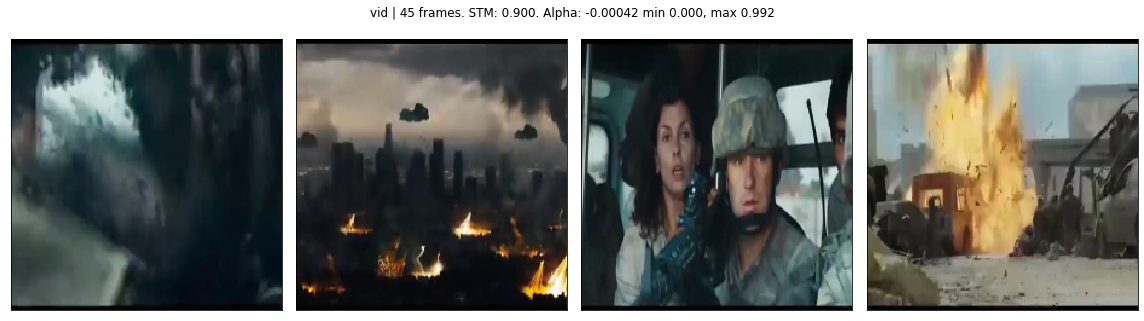

Embedding label stats:
Len: 1024, Mean: 0.0014, SD: 0.6237
Distance to negative example: 6.2064
mem, alpha, np.max(b), np.min(b) 0.7670558554045052 -0.0010484346470067299 255.0 0.0


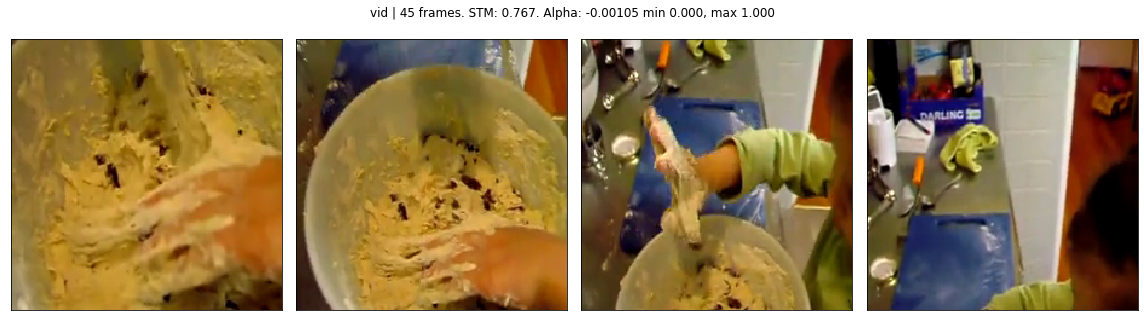

Embedding label stats:
Len: 1024, Mean: 0.0012, SD: 0.5844
Distance to negative example: 5.4752
mem, alpha, np.max(b), np.min(b) 0.9963883315496602 0.00018440988853262442 255.0 0.0


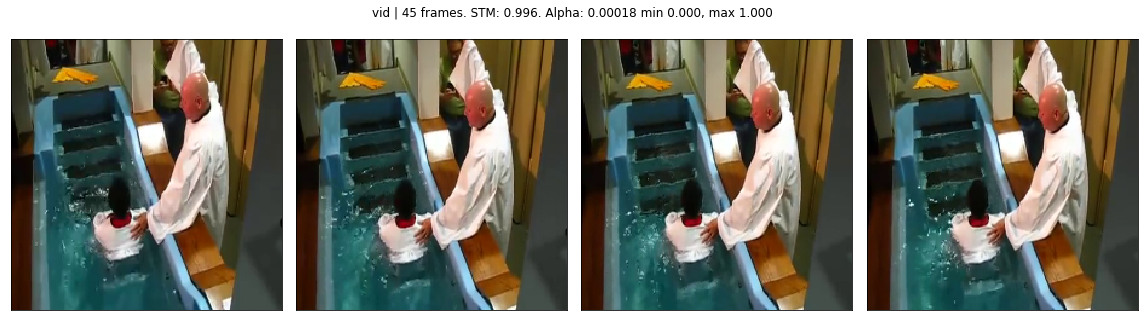

Embedding label stats:
Len: 1024, Mean: 0.0014, SD: 0.6009
Distance to negative example: 6.3595
mem, alpha, np.max(b), np.min(b) 0.535295660024824 -0.00253074814980925 255.0 0.0


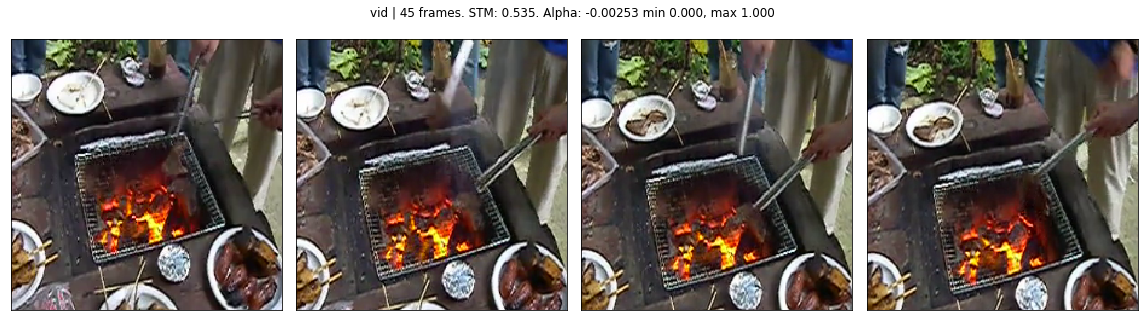

Embedding label stats:
Len: 1024, Mean: 0.0011, SD: 0.6027
Distance to negative example: 6.9262
mem, alpha, np.max(b), np.min(b) 0.740538724287311 -0.0012415454085240609 148.0 0.0


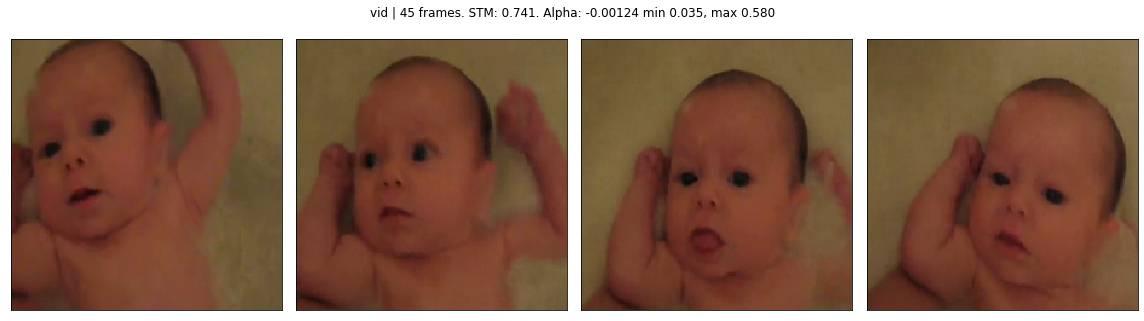

Embedding label stats:
Len: 1024, Mean: 0.0012, SD: 0.6262
Distance to negative example: 4.4211
mem, alpha, np.max(b), np.min(b) 0.7254743616823356 -0.0013517410973496698 255.0 0.0


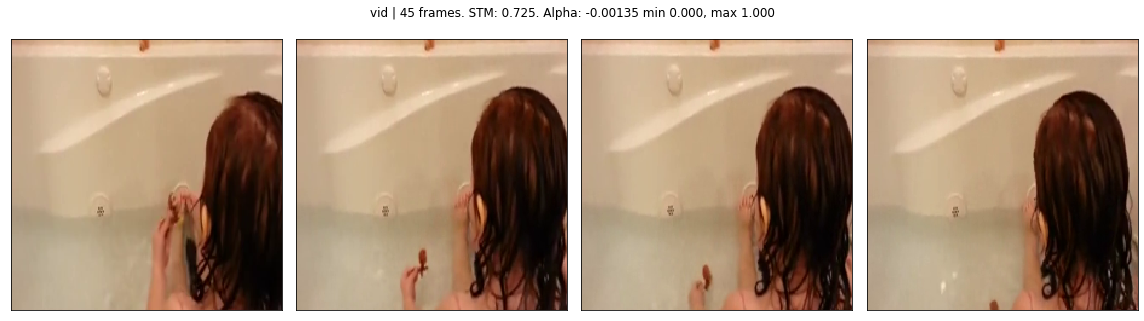

Embedding label stats:
Len: 1024, Mean: 0.0006, SD: 0.6139
Distance to negative example: 5.7972
mem, alpha, np.max(b), np.min(b) 0.6076483468822257 -0.001651029629135184 255.0 0.0


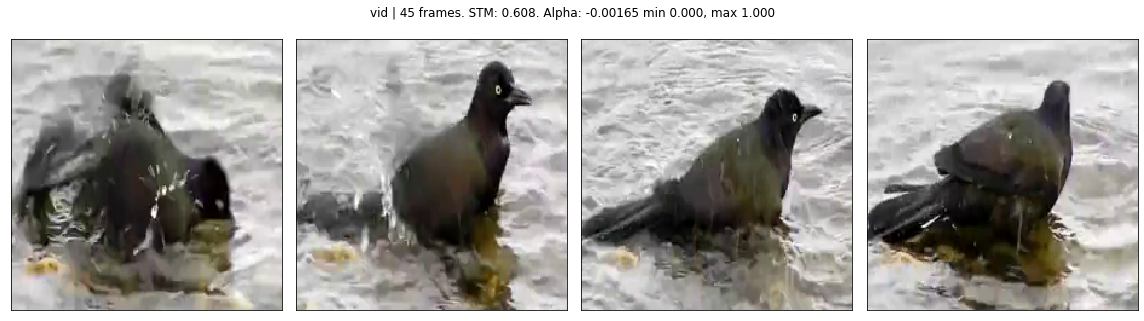

Embedding label stats:
Len: 1024, Mean: 0.0014, SD: 0.5871
Distance to negative example: 5.2847
mem, alpha, np.max(b), np.min(b) 0.7902765783528249 -0.0006443065830043351 242.0 0.0


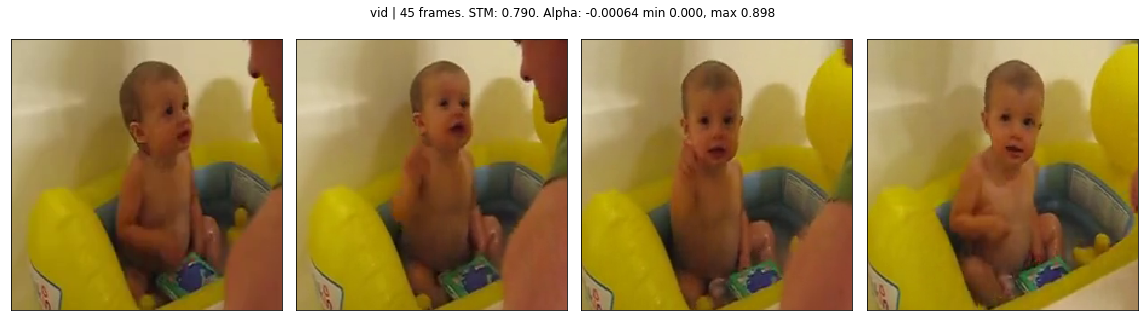

Embedding label stats:
Len: 1024, Mean: 0.0010, SD: 0.5615
Distance to negative example: 5.4910
mem, alpha, np.max(b), np.min(b) 0.8124904882299556 -0.0009142026766458495 255.0 0.0


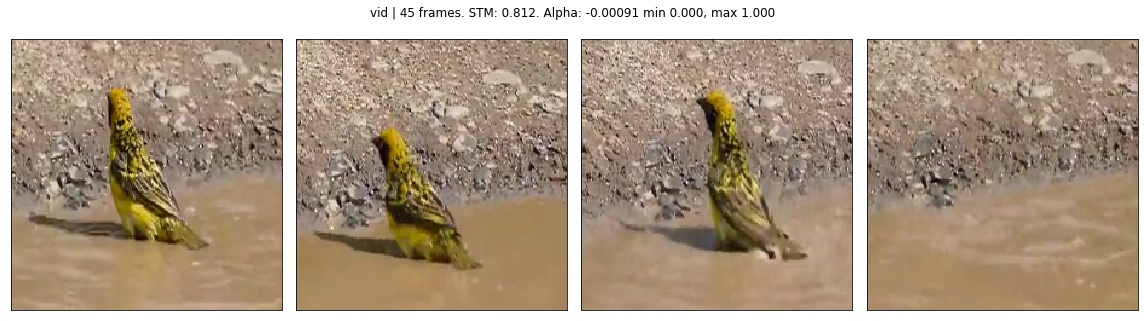

Embedding label stats:
Len: 1024, Mean: 0.0002, SD: 0.6151
Distance to negative example: 5.7518
mem, alpha, np.max(b), np.min(b) 0.7512155947002037 -0.0010247029746233089 255.0 0.0


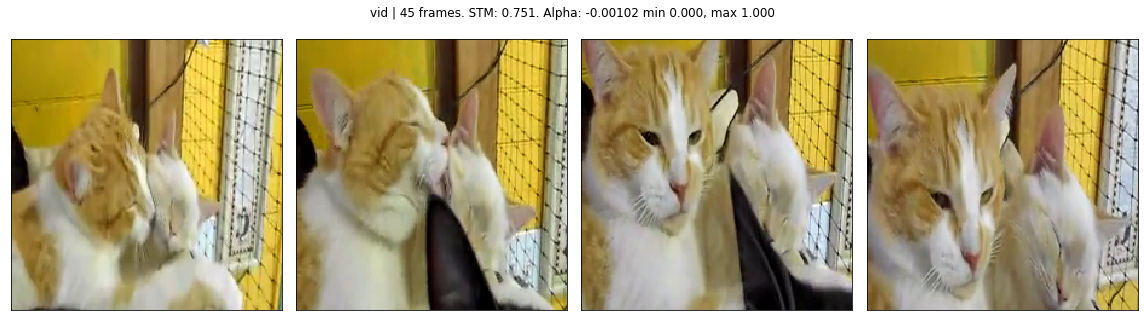

Embedding label stats:
Len: 1024, Mean: 0.0013, SD: 0.6313
Distance to negative example: 5.9846
mem, alpha, np.max(b), np.min(b) 0.7140094201714466 -0.001977168099038096 255.0 0.0


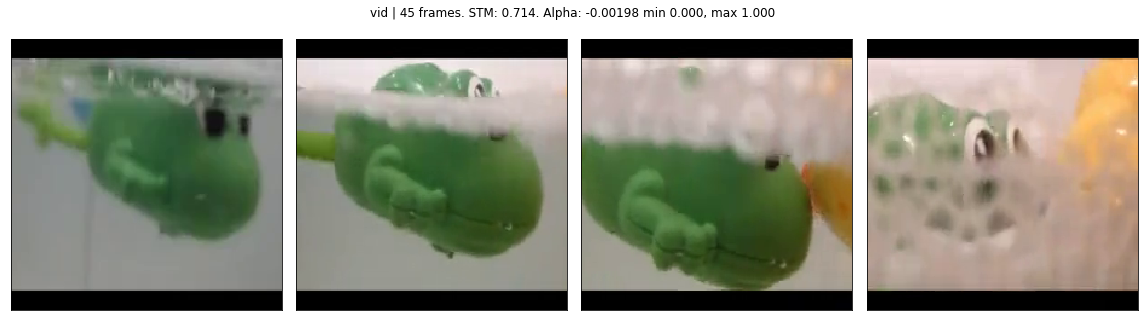

Embedding label stats:
Len: 1024, Mean: 0.0009, SD: 0.6366
Distance to negative example: 5.7776
mem, alpha, np.max(b), np.min(b) 0.7584537723501444 -0.0011990421771373092 255.0 0.0


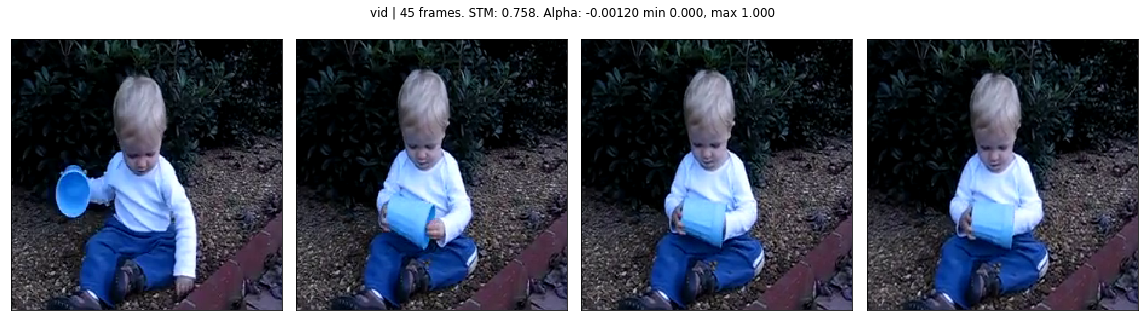

Embedding label stats:
Len: 1024, Mean: 0.0014, SD: 0.5961
Distance to negative example: 5.6663
mem, alpha, np.max(b), np.min(b) 0.7422603301839066 -0.0018686408050149167 255.0 0.0


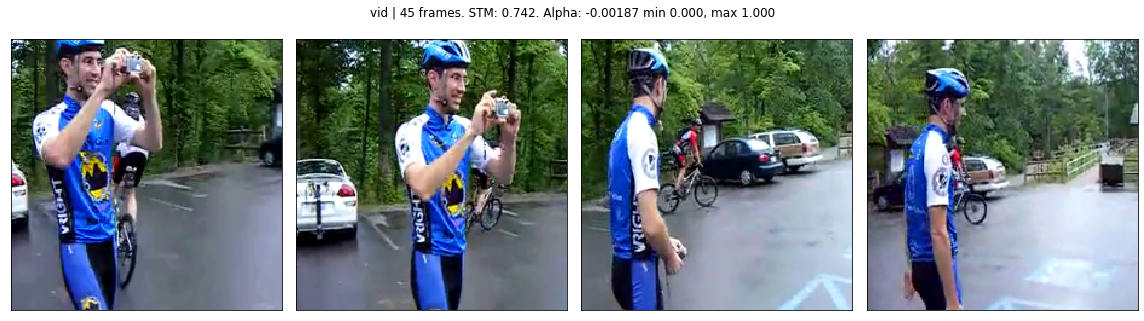

In [11]:
# Test with one batch of memento training

ret = gen_val.__getitem__(0) #np.random.randint(len(gen_val)))

video_batch=ret[0]
labels=ret[1]


# Display
for i,b in enumerate(video_batch):
    
    (mem,alpha) = labels[0][i]
    emb_label = labels[1][i]
    
    print("Embedding label stats:")
    print("Len: %d, Mean: %.4f, SD: %.4f" % (len(emb_label[0]), np.mean(emb_label[0]), np.std(emb_label[0])))
    print("Distance to negative example: %.4f" % np.linalg.norm(emb_label[0]-emb_label[1]))
    print('mem, alpha, np.max(b), np.min(b)',mem, alpha, np.max(b), np.min(b))
    
    plot_frames(b, 
                title='%s | %d frames. STM: %.3f. Alpha: %.5f' % ('vid',len(b),mem,alpha),
                is_optical_flow=True if data_type=='flow' else False,
                suptitle_y=0.89,
                is_255image=True, 
                frames_to_show=4)

# Model

In [12]:
# Fetching pretrained i3d


i3d = build_model_multigpu(type=data_type, 
                           model_type='i3d_emb',
                           image_size=cfg._IMAGE_SIZE,
                           num_frames=cfg._NUM_FRAMES, 
                           num_classes=2,
                           gpus=gpus,
                           use_pretrained=True, 
                           verbose=True, 
                           download_weights=True,
                           downsample_factor=None, 
                           dropout_prob=do, 
                           final_activation='tanh', 
                           show_internal_summary=False,
                           rescale=resc)


Working with single GPU
x.shape after downsa: (None, 23, 28, 28, 192)
channels_last
x.shape after last conv: (None, 5, 1, 1, 400)
Loading downloaded weights into model: rgb_imagenet_and_kinetics from path: /home/camilo/.keras/models/i3d_inception_rgb_imagenet_and_kinetics.h5
video_repr shape before last conv (None, 5, 1, 1, 1024)
x.shape after last conv (None, 5, 1, 1, 2)
tensor shape before entering dense_emb_out (None, 1, 1024)
Model: "i3d_full"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            (None, 45, 224, 224, 0                                            
__________________________________________________________________________________________________
lambda_2 (Lambda)               (None, 45, 224, 224, 0           input_2[0][0]                    
_____________________________________________________

In [13]:
%%bash
cd ../ckpt/i3d
ls

memento10k_flow_ep02_valloss8.4081.hdf5
memento10k_flow_ep03_valloss8.4215.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_a0b1c0_w1_gpus1_bs8_do0.50_ep18_valloss0.0318_valrc0.3915.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_a0b1c0_w1_gpus1_bs8_do0.50_ep24_valloss0.0318_valrc0.3913.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_a1b100c10_w1_gpus1_bs8_do0.50_ep01_valloss6.5899_valrc0.5125.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_a1b100c10_w1_gpus1_bs8_do0.50_ep01_valloss7.1522_valrc0.4311.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_a1b100c10_w1_gpus1_bs8_do0.50_ep01_valloss7.5053_valrc0.5007.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_a1b100c10_w1_gpus1_bs8_do0.50_ep02_valloss6.4512_valrc0.5129.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_a1b100c10_w1_gpus1_bs8_do0.50_ep02_valloss6.5719_valrc0.5168.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_a1b100c10_w1_gpus1_bs8_do0.50_ep02_valloss6.5733_valrc0.4976.hdf5
memento10k_flow_fzn0_resc1_LTalphamse_a1b100c10_w1_gpus1_bs8_do0.50_ep03_valloss6.4578_valrc0.

In [14]:
# Load weights 
W = '../ckpt/i3d/memento10k_rgb_fzn0_resc1_LTalphamse_a1b100c10_w1_gpus1_bs8_do0.30_ep07_valloss6.8248_valrc0.5935.hdf5' #None #'../ckpt/i3d/memento10k_flow_ep06_valloss8.8485.hdf5'
if W:
    i3d.load_weights(W, by_name=True)

In [15]:
# TESTING LOSS
loss = triplet_loss

for i in range(5):
    ret = gen_train.__getitem__(i)
    batch = ret[0]
    labels = ret[1]
    
    preds = i3d.predict(batch)
    l = loss(K.variable(labels[1]), K.variable(preds[1]))
    print(l)
    
# TESTING LOSS

loss = loss_alpha_mse(a=0.1, b=100, c=1000, bs=bs, 
                   T=80., pts=100, print_=True)

for i in range(5):
    ret = gen_train.__getitem__(i)
    batch = ret[0]
    labels = ret[1]
    
    preds = i3d.predict(batch)
    l = loss(K.variable(labels[0]), K.variable(preds[0]))
    print(l)


Total time on this batch: 0.9608992550056428  - it: 0 - idx: 0
Time loading: 0.538929974893108
Time preprocessing: 0.41889184596948326
Time augmenting: 0.003077434143051505
tf.Tensor(183.52223, shape=(), dtype=float32)
tf.Tensor(187.02559, shape=(), dtype=float32)
tf.Tensor(183.89905, shape=(), dtype=float32)
tf.Tensor(186.4179, shape=(), dtype=float32)
tf.Tensor(188.1336, shape=(), dtype=float32)
line_loss, K.mean(mse_mem), K.mean(mse_alpha):  2.4542722702026367 7.821021229028702 0.16564865654800087
tf.Tensor(10.440942, shape=(), dtype=float32)
line_loss, K.mean(mse_mem), K.mean(mse_alpha):  2.2943843841552733 7.0121899247169495 0.1555249618832022
tf.Tensor(9.462099, shape=(), dtype=float32)
line_loss, K.mean(mse_mem), K.mean(mse_alpha):  1.7612010955810549 3.9992444217205048 0.1675234962021932
tf.Tensor(5.927969, shape=(), dtype=float32)
line_loss, K.mean(mse_mem), K.mean(mse_alpha):  2.1784191131591797 5.97418025135994 0.2165398036595434
tf.Tensor(8.369139, shape=(), dtype=float32)

# Train last layers

In [16]:
### print('TRAINING WITH %d GPUS'%gpus)

for l in i3d.layers:
    if l.name == 'i3d_inception':
        l.trainable=False
#     if l.name == 'Conv3d_6a_1x1_conv':
#         l.trainable=False

# Define optimizer
lr=0.001
optimizer = Adam(lr=lr)

print('Compiling model')

# Compile model
a=1
b=100
c=1000
i3d.compile(optimizer=optimizer,
              loss=[loss_alpha_mse(a,b,c,bs=bs,T=T) if loss_type=='alphamse' else loss_alpha(bs=bs,T=T), triplet_loss],
              metrics=['mse'])
    
use_rc=True
ckpt_filepath = get_ckpt_name('../ckpt/i3d_emb', dataset, data_type, True, resc, gpus, bs, loss_type, use_sw, do, a,b,c)
cbs = define_callbacks(ckpt_filepath, gen_val, name_to_mem_alpha, val_names, 
                      lr=lr, drop=0.1, epochs_drop=10, ckpt_period=1, use_cb_rankcorr=use_rc)


print('Ready to train last layer')
print('ckpt_filepath:',ckpt_filepath)

# Training
i3d.fit_generator(gen_train, 
                  epochs=10,
                  verbose=1, 
                  callbacks=cbs, 
                  max_queue_size=100,
                  validation_data=gen_val, 
                  workers=10)


Compiling model
Ready to train last layer
ckpt_filepath: ../ckpt/i3d_emb/memento10k_rgb_fzn1_resc1_LTalphamse_a1b100c1000_w1_gpus1_bs20_do0.30_ep{epoch:02d}_valloss{val_loss:.4f}_valrc{rc_val:.4f}.hdf5
Epoch 1/10
350/350 [==============================] - 419s 1s/step - loss: 0.5253 - prediction_loss: 0.0995 - dense_emb_out_loss: 0.4259 - prediction_mse: 0.0122 - dense_emb_out_mse: 0.2897 - val_loss: 0.2998 - val_prediction_loss: 0.0540 - val_dense_emb_out_loss: 0.4168 - val_prediction_mse: 0.0129 - val_dense_emb_out_mse: 0.2819
PREDICTING FOR RANK CORRELATION...
75/75 [==============================] - 71s 952ms/step
len(p1) 1500

 --- VAL RANK CORR: 0.50839 --- 



Epoch 00001: saving model to ../ckpt/i3d_emb/memento10k_rgb_fzn1_resc1_LTalphamse_a1b100c1000_w1_gpus1_bs20_do0.30_ep01_valloss0.2998_valrc0.5084.hdf5
Epoch 2/10
 40/350 [==>...........................] - ETA: 5:03 - loss: 0.5949 - prediction_loss: 0.1589 - dense_emb_out_loss: 0.4360 - prediction_mse: 0.0119 - dense_emb_ou

# Train full network

In [17]:
print('TRAINING WITH %d GPUS'%gpus)

for l in i3d.layers:
    l.trainable = True

        
lr=0.0001
optimizer = Adam(lr=lr)

a=1
b=100
c=1000
i3d.compile(optimizer=optimizer,
              loss=[loss_alpha_mse(a,b,c,bs=bs,T=T) if loss_type=='alphamse' else loss_alpha(bs=bs,T=T), triplet_loss],
              metrics=['mse'])
    
use_rc=True
ckpt_filepath = get_ckpt_name('../ckpt/i3d_emb', dataset, data_type, False, resc, gpus, bs, loss_type, use_sw, do, a,b,c)
cbs = define_callbacks(ckpt_filepath, gen_val, name_to_mem_alpha, val_names, 
                      lr=lr, drop=0.1, epochs_drop=10, ckpt_period=1, use_cb_rankcorr=use_rc)


    
print('Ready to train full net')

# Training
i3d.fit_generator(gen_train, 
                  epochs=30,
                  verbose=1, 
                  callbacks=cbs, 
                  max_queue_size=100,
                  validation_data=gen_val, 
                  workers=10)


TRAINING WITH 1 GPUS
Ready to train full net
Epoch 1/30
349/350 [============================>.] - ETA: 1s - loss: 0.4377 - prediction_loss: 0.0304 - dense_emb_out_loss: 0.4073 - prediction_mse: 0.0109 - dense_emb_out_mse: 0.2810
Total time on this batch: 3.2753994641825557  - it: 4000 - idx: 227
Time loading: 1.595505379140377
Time preprocessing: 1.6797999190166593
Time augmenting: 9.416602551937103e-05
350/350 [==============================] - 771s 2s/step - loss: 0.4449 - prediction_loss: 0.0310 - dense_emb_out_loss: 0.4139 - prediction_mse: 0.0110 - dense_emb_out_mse: 0.2810 - val_loss: 0.2877 - val_prediction_loss: 0.0384 - val_dense_emb_out_loss: 0.4145 - val_prediction_mse: 0.0124 - val_dense_emb_out_mse: 0.2803
PREDICTING FOR RANK CORRELATION...
75/75 [==============================] - 72s 956ms/step
len(p1) 1500

 --- VAL RANK CORR: 0.52089 --- 



Epoch 00001: saving model to ../ckpt/i3d_emb/memento10k_rgb_fzn0_resc1_LTalphamse_a1b100c1000_w1_gpus1_bs20_do0.30_ep01_valloss0.

KeyboardInterrupt: 

# Show some results

In [ ]:
def show_results(model, inputs, labels):
    
    preds = model.predict(inputs)
    
    mem_and_alpha = preds[0]
    captions = preds[1]
    
    for i in range(len(mem_and_alpha)):
        
        predmem = mem_and_alpha[i][0]
        predalpha = mem_and_alpha[i][1]
        
        mem = labels[0][i][0]
        alpha = labels[0][i][1]
        
        pred_cap = captions[i]
        true_cap = labels[1][i]
        
        # Show input video, predicted mem and alpha with true mem and alpha
        plot_frames(inputs[0][i], 
                    title='pred mem: %.3f. True: %.3f. pred alpha: %.5f. True: %.5f --' % (predmem, mem, predalpha, alpha),
                    is_optical_flow=False,
                    suptitle_y=0.89,
                    is_255image=True, 
                    frames_to_show=4)
        
        # Print predicted caption and true caption
        if caption_format=='index_triangular_matrix':
            print("Input caption:", to_words(inputs[1][i]))
            print("word to predict:", to_words(np.argmax(true_cap)))
            print("predicted word:", to_words(np.argmax(pred_cap)))
        else:
            print("Input caption:", to_words(inputs[1][i]))
            print("seq to predict:", to_words([np.argmax(w) for w in true_cap]))
            print("predicted seq:", to_words([np.argmax(w) for w in pred_cap]))
            
    
        
show_results(i3d, *gen_val.__getitem__(2))

# Generate captions

In [ ]:

word2idx['0']=0

def generate_captions_sentence(model, input_video, max_cap_len=50, verbose=True, gr_truth_cap = None):

#     print(gr_truth_cap, gr_truth_cap.shape)
    print(input_video.shape)
    if gr_truth_cap is not None:
        input_cap = gr_truth_cap
    else:
        input_cap = np.array([word2idx['<start>']])

    for i in range(max_cap_len-1):
#         print(to_words(input_cap[:i+1]))
        mem_alpha, cap = model.predict([[input_video], [input_cap[:i+1]]])
        print("prediction:", " ".join(to_words([np.argmax(w) for w in cap[0]])))
        predicted_word = np.argmax(cap[0][i])
        if gr_truth_cap is None:
            input_cap = np.append(input_cap,predicted_word)
#         if verbose: print("predicted word:", to_words(predicted_word))
        
        if predicted_word == word2idx['<end>']:
            break

    print("Final predicted caption:", " ".join(to_words(input_cap)))

    return input_cap

def generate_captions_wordbyword(ckpt):
    
    model = build_model_multigpu(type=data_type, 
                               model_type='i3d_cap_sentence_early',
                               image_size=cfg._IMAGE_SIZE,
                               num_frames=cfg._NUM_FRAMES, 
                               num_classes=2,
                               gpus=gpus,
                               use_pretrained=True, 
                               verbose=True, 
                               download_weights=True,
                               downsample_factor=None, 
                               dropout_prob=do, 
                               final_activation='tanh', 
                               show_internal_summary=False,
                               rescale=resc,
                               embedding_matrix=embedding_matrix,
                               output_biases=logfreq,
                               return_states=True )
    
    
#     model.load_weights(ckpt, by_name=True)
#     encoder = build_i3d
#     decoder = captioning_module
#     decoder = Model(inputs=[word,initial_states], outputs=[word, intial_states])
    

def predict_sentence_generator(gen, model, forcing=False, show_vid=True):
    captions=[]
    
    for inputs, labels in gen:

        for i in range(gen.batch_size):
            if show_vid:
                # Show input video, predicted mem and alpha with true mem and alpha
                plot_frames(inputs[0][i], 
                            title='%s -- True mem: %.3f. True alpha: %.5f --' % (" ".join(to_words(inputs[1][i])),labels[0][i][0],labels[0][i][1]),
                            is_optical_flow=False,
                            suptitle_y=0.95,
                            is_255image=True, 
                            frames_to_show=4)
            if forcing:
                captions.append(generate_captions_sentence(model, input_video=inputs[0][i], gr_truth_cap = list(inputs[1][i])))
            else:
                captions.append(generate_captions_sentence(model, input_video=inputs[0][i]))


            
    return captions


new_W = None # '../ckpt/i3d_cap/memento10k_rgb_fzn1_resc1_LTalphamse_a1b100c10_w0_gpus1_bs32_do0.30_ep18_valloss22.1719_capacc0.273.hdf5'
if new_W:
    i3d.load_weights(new_W, by_name=True)

predict_sentence_generator(gen_val, i3d, forcing=False)    

# Test embedding module

In [ ]:
from keras_models import captioning_module_with_emb_output
max_cap_len = 50

cap_model = captioning_module_with_emb_output(Input(shape=(max_cap_len,)), embedding_matrix)

k=3
pred, emb = cap_model.predict(np.array(range(max_cap_len)).reshape(1,-1))
print("Expected embedding:", embedding_matrix[0])
print("Predicted embedding:", emb[0][0])

# Predict and Evaluate RC

In [ ]:
# Load model if necessary
# W = '../ckpt/i3d/memento10k_flow_ep10_valloss11.7493.hdf5'
# i3d.load_weights(W)

In [ ]:
# Predict

preds = i3d.predict_generator(gen_val, verbose=1)

In [ ]:

    pred_mem = [p[0] for p in preds]
    pred_alpha = [p[1] for p in preds]

    true_mem=[]
    true_alpha=[]

    verbose=False

    for i,n in enumerate(val_names[:-3]):
        if verbose:
            print('Name:',n)
            print('True mem:',name_to_mem_alpha[n][0])
            print('Pred mem:',pred_mem[i])
            print('True alpha:',name_to_mem_alpha[n][1])
            print('Pred alpha:',pred_alpha[i])
        true_mem.append(name_to_mem_alpha[n][0])
        true_alpha.append(name_to_mem_alpha[n][1])

    print('First 8 gt mem:', true_mem[:8])
    print('First 8 pred mem:', pred_mem[:8])

    # assert(len(preds)==len(val_names))

    rc = spearmanr(pred_mem, true_mem)
    alpha_rc = spearmanr(pred_alpha, true_alpha)
    

    print('RC:', rc[0])
    print('Alpha_rc:',alpha_rc[0])